In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from typing import List, Tuple
import numpy as np
from utils import BrainGraphDataset
import os
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int, dropout: float = 0., l2_strength=0.01):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim)
        )
        
        self.l2_strength = l2_strength

        
    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        
        return x_recon, mu, logvar, z

    def loss(self, x_recon, x, mu, logvar, n_components=3):
        MSE = nn.functional.mse_loss(x_recon, x, reduction='sum')

        # Calculate the GMM loss
        gmm = GaussianMixture(n_components=n_components)
        z = mu.detach().cpu().numpy()
        gmm.fit(z)
        gmm_loss = -gmm.score(z)

        # L2 regularization
        l2_loss = 0.
        for name, param in self.encoder.named_parameters():
            if 'weight' in name:
                l2_loss += torch.norm(param, p=2)

        for name, param in self.decoder.named_parameters():
            if 'weight' in name:
                l2_loss += torch.norm(param, p=2)

        # Add L2 regularization loss
        loss = MSE + gmm_loss + self.l2_strength * l2_loss

        return loss


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
input_dim = 100 * 100  # size of the graph adjacency matrix
hidden_dim = 256
latent_dim = 64
lr = 1e-3
batch_size = 128
num_epochs = 200

annotations = 'annotations.csv'
dataroot = 'fc_matrices/hcp_100_ica/'
cwd = os.getcwd() + '/'

dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + dataroot + annotations,
                            transform=None, extra_data=None, setting='no_label')

dataroot = 'fc_matrices/psilo_ica_100_before/'
psilo_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + annotations,
                            transform=None, extra_data=None, setting='no_label')

psilo_train_loader = DataLoader(psilo_dataset, batch_size=batch_size)

train_dataset = dataset
val_dataset = psilo_dataset

# define the data loaders
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = psilo_train_loader

dropout_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

# define a dictionary to store the loss curves for each configuration
loss_curves = {}

# for dropout in dropout_list:
#     for l2_strength in [0.001, 0.01]:
#         best_val_loss = float('inf')  # set to infinity to start
#         best_model_state = None
#         train_losses = []
#         val_losses = []
#         model = VAE(input_dim, hidden_dim, latent_dim, dropout=dropout, l2_strength=l2_strength).to(device)  # move model to device
#         optimizer = optim.Adam(model.parameters(), lr=lr)

#         with open('dropout_train.txt', 'a') as f:
#             f.write(f'Dropout {dropout}\n')

#         for epoch in tqdm(range(num_epochs)):
#             train_loss = 0.0
#             val_loss = 0.0

#             # training
#             model.train()
#             for batch_idx, (data, _) in enumerate(train_loader):
#                 data = data.to(device)  # move data to device
#                 optimizer.zero_grad()

#                 recon, mu, logvar, _ = model(data.view(-1, input_dim))
#                 loss = model.loss(recon, data.view(-1, input_dim), mu, logvar, n_components=3)
#                 loss.backward()
#                 optimizer.step()
#                 train_loss += loss.item()

#             # validation
#             model.eval()
#             with torch.no_grad():
#                 for batch_idx, (data, _) in enumerate(val_loader):
#                     data = data.to(device)  # move data to device
#                     recon, mu, logvar, _ = model(data.view(-1, input_dim))
#                     loss = model.loss(recon, data.view(-1, input_dim), mu, logvar, n_components=3)

#                     val_loss += loss.item()

#             # append losses to lists
#             train_losses.append(train_loss/len(train_dataset))
#             val_losses.append(val_loss/len(val_dataset))

#             # save the model if the validation loss is at its minimum
#             if val_losses[-1] < best_val_loss:
#                 best_val_loss = val_losses[-1]
#                 best_model_state = model.state_dict().copy()

#             # print the losses
#             with open('dropout_train.txt', 'a') as f:
#                 f.write(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')

#         # save the best model for this configuration
#         torch.save(best_model_state, f'vgae_weights/dropout_{dropout}_{l2_strength}_best.pt')

#         # add the loss curves to the dictionary
#         loss_curves[f"dropout_{dropout}_{l2_strength}"] = {"train_loss": train_losses, "val_loss": val_losses}

# # save the loss curves to a file
# with open("loss_curves_reg2.json", "w") as f:
#     json.dump(loss_curves, f)

cpu


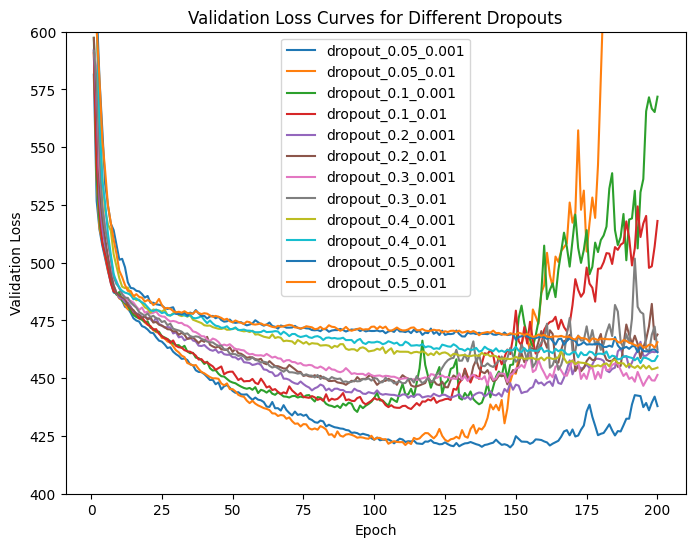

In [17]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curves_reg2.json", "r") as f:
    loss_curves = json.load(f)

# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))
for n_comp, loss_dict in loss_curves.items():

    val_losses = loss_dict["val_loss"]
    epochs = range(1, len(val_losses) + 1)
    plt.plot(epochs, val_losses, label=f"{n_comp}")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for Different Dropouts")
plt.legend()
plt.ylim((400, 600))

# show the plot
plt.show()


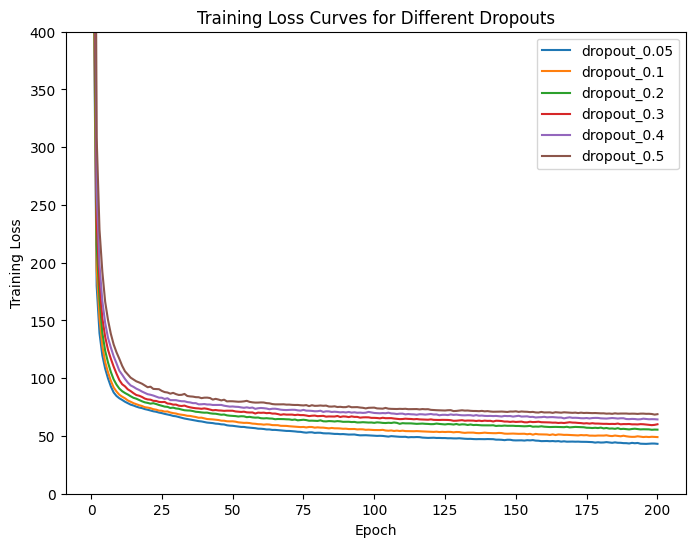

In [15]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curves_reg.json", "r") as f:
    loss_curves = json.load(f)

# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))
for n_comp, loss_dict in loss_curves.items():
    val_losses = loss_dict["train_loss"]
    epochs = range(1, len(val_losses) + 1)
    plt.plot(epochs, val_losses, label=f"{n_comp}")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Different Dropouts")
plt.legend()
plt.ylim((0, 400))


# show the plot
plt.show()


In [18]:
# load in the models and get the validation loss for each
models = []
val_losses = []

for l2_strength in [0.01, 0.001]:
    for dropout in dropout_list:
        # instantiate the model
        model = VAE(input_dim, hidden_dim, latent_dim)

        # load the weights
        model.load_state_dict(torch.load(f'vgae_weights/dropout_{dropout}_{l2_strength}_best.pt', map_location=device))

        # set the model to evaluation mode
        model.eval()

        # calculate the validation loss
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(val_loader):
                recon, mu, logvar, _ = model(data.view(-1, input_dim))
                loss = model.loss(recon, data.view(-1, input_dim), mu, logvar, n_components=3)
                val_loss += loss.item()
        val_losses.append(val_loss/len(psilo_dataset))
        models.append(model)

# print the validation loss for each model
for i, val_loss in enumerate(val_losses):
    print(f'Dropout {dropout_list[i]}: Validation Loss = {val_loss:.4f}')

Dropout 0.05: Validation Loss = 674.1982
Dropout 0.1: Validation Loss = 519.5957
Dropout 0.2: Validation Loss = 469.1410
Dropout 0.3: Validation Loss = 462.7766
Dropout 0.4: Validation Loss = 460.1395
Dropout 0.5: Validation Loss = 465.5856


IndexError: list index out of range

In [9]:
model = VAE(input_dim, hidden_dim, latent_dim)
# load the weights
model.load_state_dict(torch.load(f'vgae_weights/dropout_0.05_0.01_best.pt', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

<All keys matched successfully>

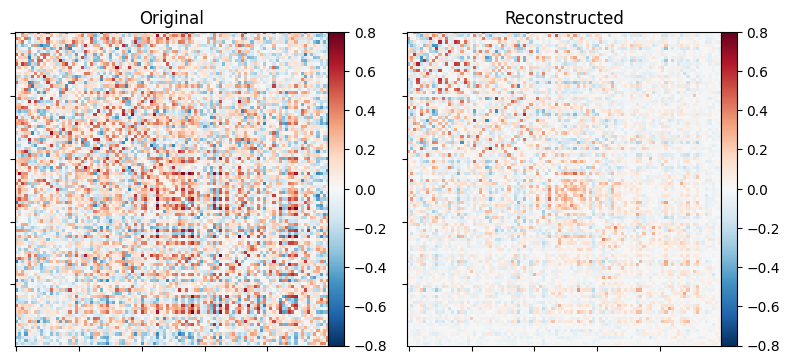

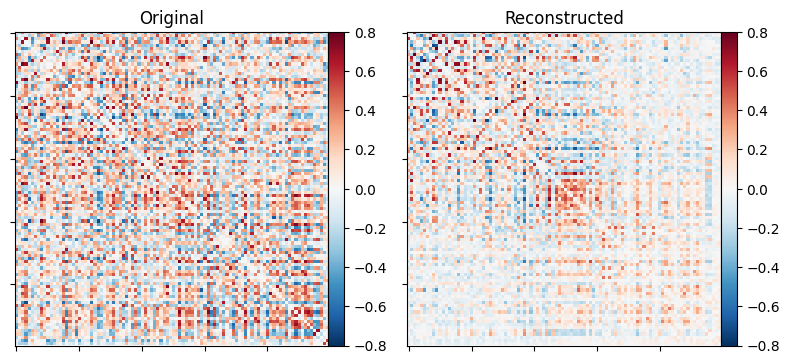

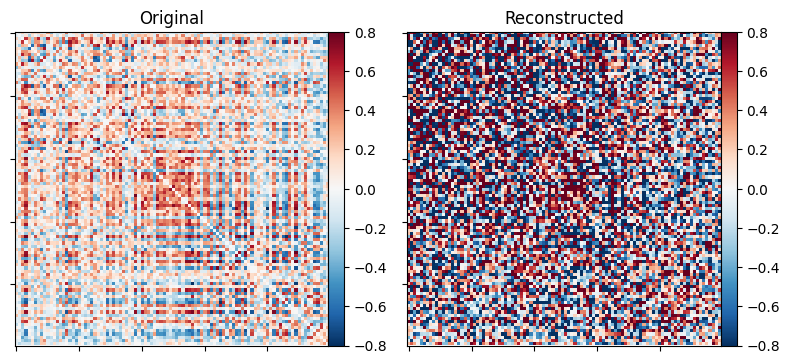

In [10]:
import matplotlib.pyplot as plt
from nilearn import plotting

# select a batch from the validation data loader
data, _ = next(iter(val_loader))

# pass the batch through the trained model to obtain the reconstructed output
recon, _, _, _ = model(data.view(-1, input_dim))

# reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)
recon = recon.view(-1, 100, 100)

for i in range(3):
    # plot the original and reconstructed matrices for the first sample in the batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plotting.plot_matrix(data[i], colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
    ax1.set_title('Original')
    plotting.plot_matrix(recon[i].detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
    ax2.set_title('Reconstructed')
    plt.show()

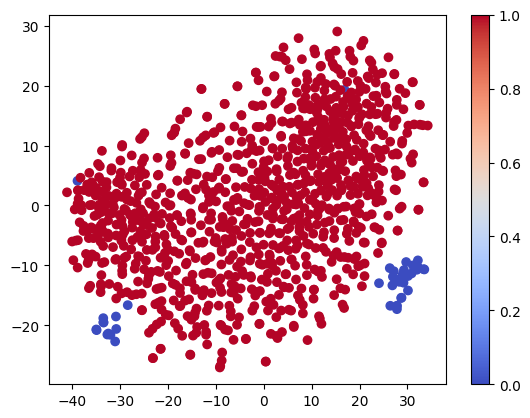

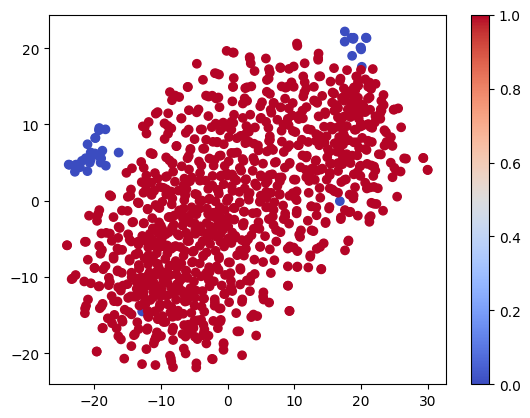

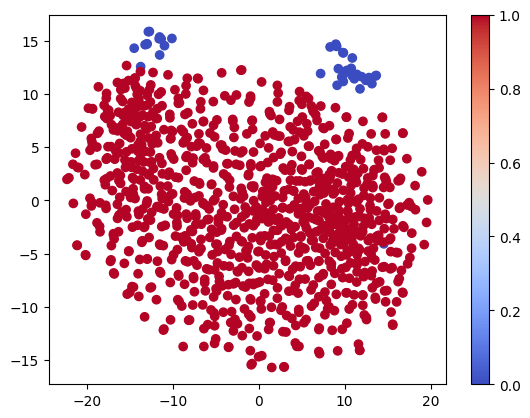

In [11]:
hidden_dim = 256
latent_dim = 64
input_dim = 100 * 100

model = VAE(input_dim, hidden_dim, latent_dim)

model.load_state_dict(torch.load('vgae_weights/dropout_0.05_0.01_best.pt', map_location=device))

psilo_zs = []
hcp_zs = []

with torch.no_grad():
    for batch_idx, (data, _) in enumerate(psilo_train_loader):
        _, _, _, z = model(data.view(-1, input_dim))
        psilo_zs.append(z)
    
    for batch_idx, (data, _) in enumerate(train_loader):
        _, _, _, z = model(data.view(-1, input_dim))
        hcp_zs.append(z)

psilo_zs = torch.cat(psilo_zs, dim=0)
hcp_zs = torch.cat(hcp_zs, dim=0)
        
# Concatenate the encoded representations and create labels
x = torch.cat((psilo_zs, hcp_zs), dim=0)
labels = torch.cat((torch.zeros(psilo_zs.shape[0]), torch.ones(hcp_zs.shape[0])), dim=0)

from sklearn.manifold import TSNE

for per in [30, 40, 50]:
    # Use t-SNE to reduce the dimensionality of the encoded representations
    tsne = TSNE(n_components=2, perplexity=per, n_iter=1000)
    x_tsne = tsne.fit_transform(x)

    # Plot the t-SNE embeddings
    plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap='coolwarm')
    plt.colorbar()
    plt.show()